In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


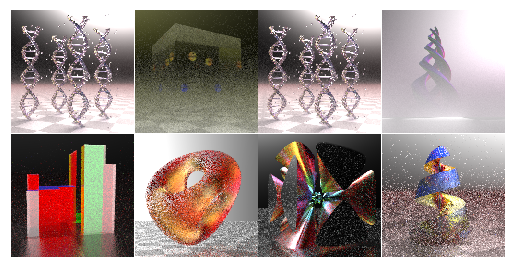

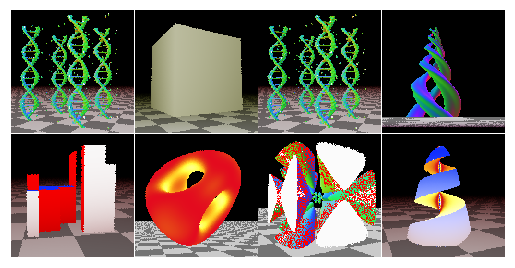

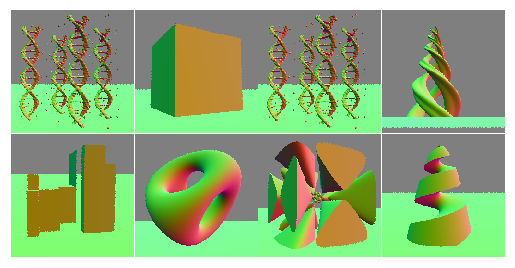

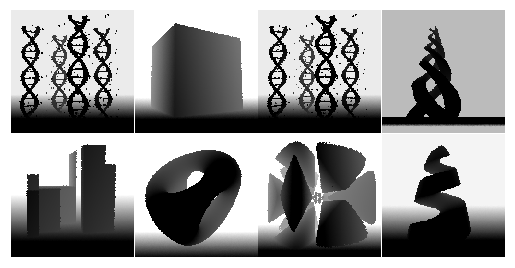

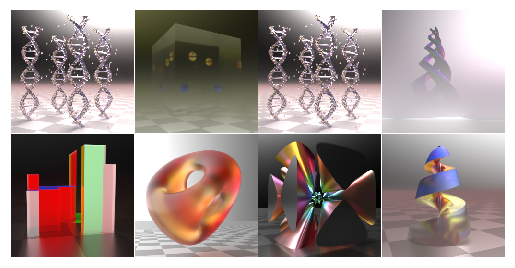

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 32
        n3 = 48
        n4 = 64
        # self.econv0 = conv3(10, n0) # 1
        self.econv0a = conv3(10, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.econv3 = conv3(n2, n3) # 1/8
        self.mconv1 = conv3(n3, n4) # 1/16
        self.mconv2 = conv3(n4, n4) # 1/16
        self.dconv3a = dconv4(n4, n3) # 1/16->1/8
        self.dconv3b = conv3(n3+n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        # self.dconv0b = conv3(n0+n0, 3) # 1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        # e0 = self.econv0(input) # 1
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        e3 = self.econv3(pool(e2)) # 1/8
        m1 = self.mconv1(pool(e3)) # 1/16
        m2 = self.mconv2(relu(m1)) # 1/16
        d3 = relu(self.dconv3a(relu(m2))) # 1/8
        d3 = relu(self.dconv3b(concat(d3, e3))) # 1/8
        d2 = relu(self.dconv2a(d3)) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        # return d0
        # return d0 + input[:, :3]
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv3a): ConvTranspose2d(64, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv3b): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(48,

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
256 0.054302141070365906
512 0.05742942541837692
768 0.031139321625232697
1024 0.03247943893074989
1280 0.037361230701208115
1536 0.0344122089445591
1792 0.04960169643163681
2048 0.032136186957359314
2304 0.02620793879032135
2560 0.03710884973406792
2816 0.037027470767498016
3072 0.0403728112578392
3328 0.03978865593671799
3584 0.019823018461465836
3840 0.02457202412188053
4096 0.036886394023895264
4352 0.03656250983476639
4608 0.028583861887454987
4864 0.02168409898877144
5120 0.018517855554819107
5376 0.025719627737998962
5632 0.023390887305140495
5888 0.022377019748091698
6144 0.0234339889138937
6400 0.02840707078576088
6656 0.05144989490509033
6912 0.02156861126422882
7168 0.023659221827983856
7424 0.01839233934879303
7680 0.018205586820840836
7936 0.024372264742851257
8192 

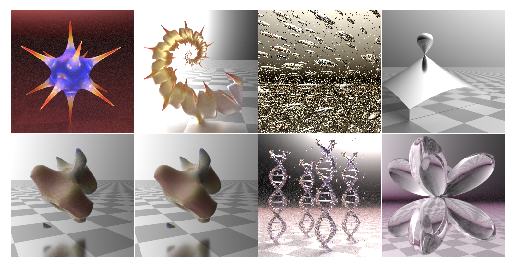

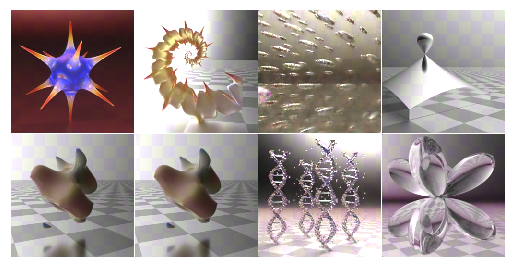

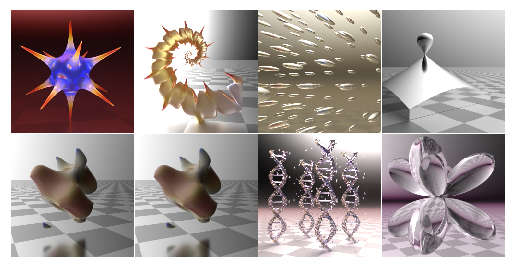

8448 0.02409072034060955
8704 0.017727740108966827
8960 0.026546549052000046
9216 0.02505660429596901
9472 0.020656384527683258
9728 0.03517695888876915
9984 0.015278320759534836
10240 0.023730089887976646
10496 0.02047555148601532
10752 0.023759156465530396
11008 0.024742145091295242
11264 0.020641088485717773
11520 0.027910737320780754
11776 0.01996028795838356
12032 0.023766066879034042
12288 0.01959553360939026
12544 0.013197461143136024
12800 0.024576395750045776
13056 0.020022518932819366
13312 0.028520990163087845
13568 0.030427778139710426
13824 0.025268200784921646
14080 0.016265492886304855
14336 0.017123879864811897
14592 0.03158661723136902
14848 0.02021842449903488
15104 0.02494887262582779
15360 0.01270685438066721
15616 0.017245884984731674
15872 0.02162700705230236
16128 0.03434230387210846
16384 0.01757778972387314


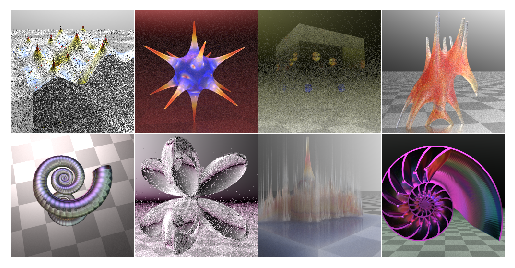

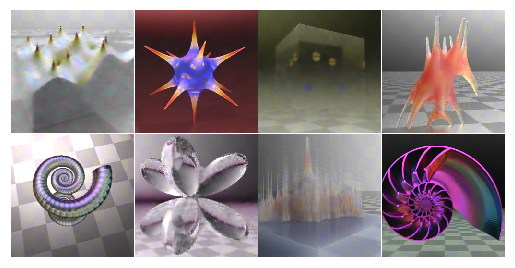

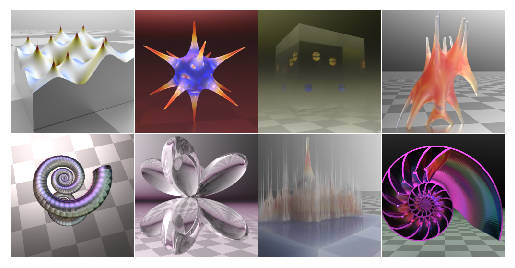

16640 0.013435992412269115
16896 0.013138627633452415
17152 0.024522989988327026
17408 0.021089699119329453
17664 0.021206069737672806
17920 0.03277101367712021
18176 0.02429589442908764
18432 0.02108476310968399
18688 0.017122451215982437
18944 0.017898984253406525
19200 0.01724226400256157
19456 0.030171364545822144
19712 0.019757483154535294
19968 0.02140740118920803
20224 0.02616467885673046
20480 0.020784789696335793
20736 0.021031316369771957
20992 0.01391028892248869
21248 0.01951437257230282
21504 0.01530028972774744
21760 0.017552122473716736
22016 0.01685255579650402
22272 0.017736652866005898
22528 0.025579597800970078
22784 0.02205783873796463
23040 0.023368485271930695
23296 0.0222982969135046
23552 0.007987585850059986
23808 0.015832044184207916
24064 0.021444611251354218
24320 0.026308570057153702
24576 0.018270518630743027


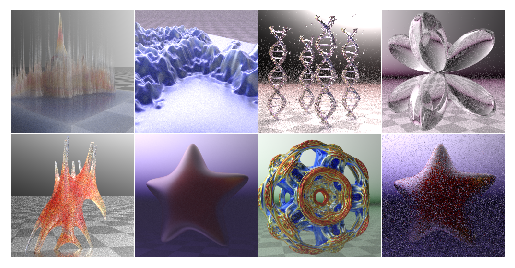

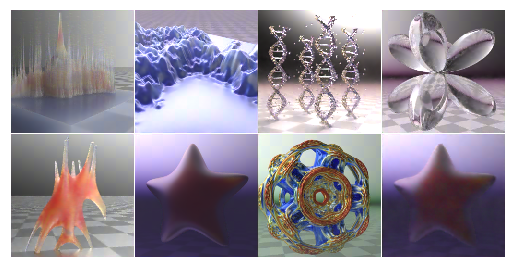

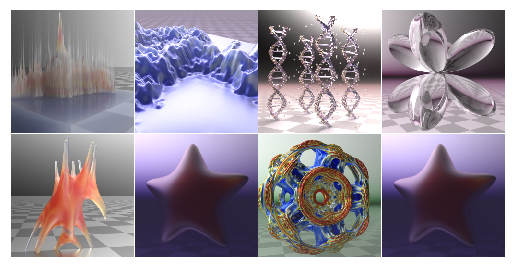

24832 0.020791705697774887
25088 0.011384094133973122
25344 0.018208205699920654
25600 0.017988575622439384
25856 0.013849947601556778
26112 0.030408117920160294
26368 0.016913369297981262
26624 0.018070435151457787
26880 0.03431638330221176
27136 0.008762119337916374
27392 0.01751735433936119
27648 0.01592046394944191
27904 0.02208300679922104
28160 0.028948552906513214
28416 0.012058556079864502
28672 0.018497096374630928
28928 0.012874558568000793
29184 0.024772875010967255
29440 0.019044801592826843
29696 0.01611657254397869
29952 0.015523874200880527
30208 0.019988125190138817
30464 0.015339242294430733
30720 0.021590525284409523
30976 0.013100456446409225
31232 0.016338566318154335
31488 0.020107856020331383
31744 0.024988437071442604
32000 0.01513432152569294
32256 0.014881451614201069
32512 0.015389496460556984
32768 0.015332479029893875


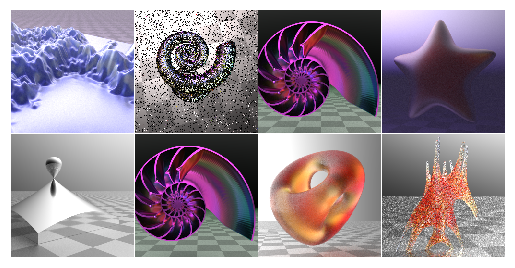

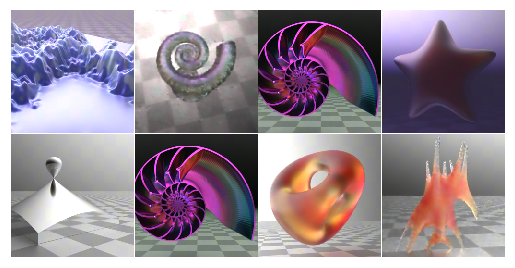

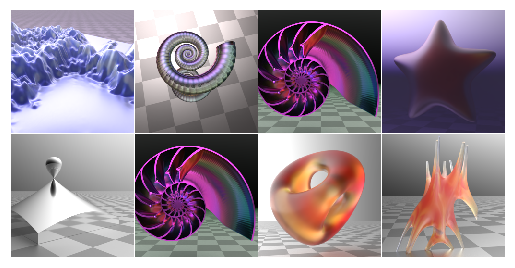

33024 0.023616470396518707
33280 0.01816776767373085
33536 0.018416989594697952
33792 0.008518945425748825
34048 0.03359505906701088
34304 0.010869227349758148
34560 0.015210012905299664
34816 0.025203194469213486
35072 0.015135127119719982
35328 0.022814830765128136
35584 0.010614154860377312
35840 0.024919532239437103
36096 0.013111195527017117
36352 0.022345038130879402
36608 0.015127306804060936
36864 0.019901761785149574
37120 0.018417207524180412
37376 0.011981425806879997
37632 0.021245060488581657
37888 0.016940776258707047
38144 0.01850450225174427
38400 0.020139232277870178
38656 0.024255307391285896
38912 0.01891389861702919
39168 0.011322135105729103
39424 0.010547935962677002
39680 0.016842545941472054
39936 0.013632019981741905
40192 0.026364460587501526
40448 0.01836450770497322
40704 0.023532837629318237
40960 0.021908923983573914


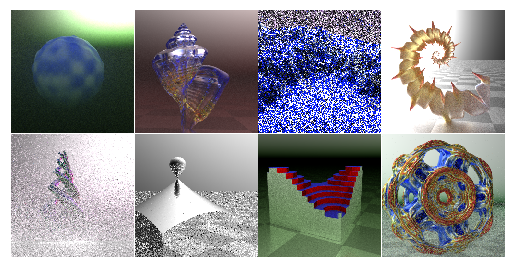

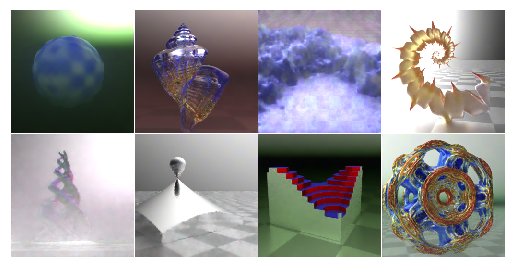

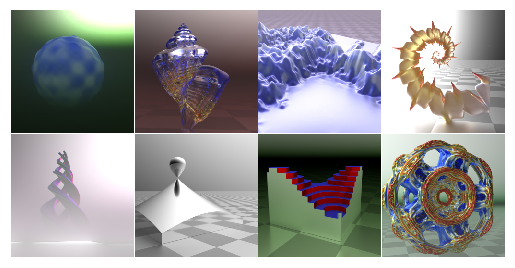

41216 0.016725042834877968
41472 0.019660357385873795
41728 0.01121481228619814
41984 0.016271468251943588
42240 0.01953582651913166
42496 0.02104189433157444
42752 0.008629746735095978
43008 0.02618379518389702
43264 0.0258350633084774
43520 0.007648821920156479
43776 0.019820561632514
44032 0.015541838482022285
44288 0.010400217026472092
44544 0.024915920570492744
44800 0.016673844307661057
45056 0.02317693457007408
45312 0.030917547643184662
45568 0.017398245632648468
45824 0.031959451735019684
46080 0.013912728056311607
46336 0.01773373782634735
46592 0.017313599586486816
46848 0.014397685416042805
47104 0.02211342379450798
47360 0.010688095353543758
47616 0.011678989976644516
47872 0.016318172216415405
48128 0.012504825368523598
48384 0.013641594909131527
48640 0.01642703078687191
48896 0.025070592761039734
49152 0.025856485590338707


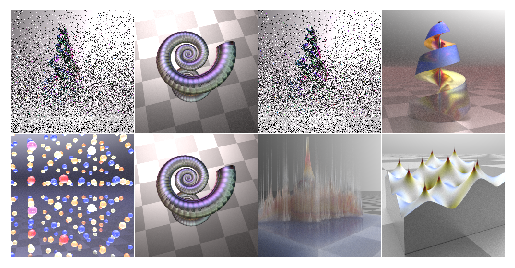

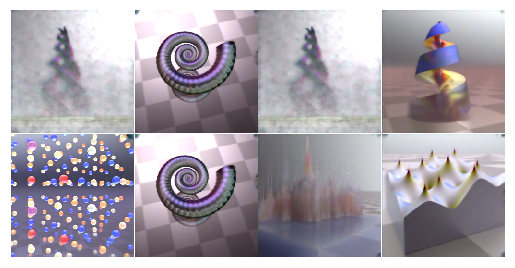

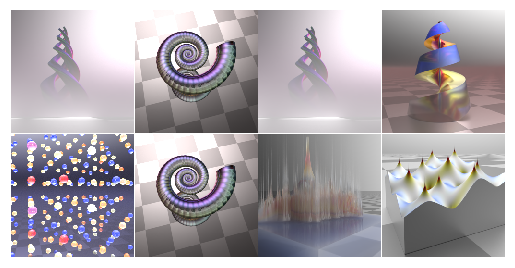

49408 0.00793095026165247
49664 0.022444341331720352
49920 0.011778533458709717
50176 0.025112681090831757
50432 0.01577604189515114
50688 0.021366585046052933
50944 0.02218179777264595
51200 0.018651260063052177
51456 0.019231881946325302
51712 0.0209273099899292
51968 0.0336800180375576
52224 0.01484309695661068
52480 0.016813190653920174
52736 0.04617498815059662
52992 0.038073305040597916
53248 0.020960163325071335
53504 0.025430673733353615
53760 0.018984749913215637
54016 0.023835603147745132
54272 0.015010535717010498
54528 0.025266148149967194
54784 0.01888950727880001
55040 0.017501983791589737
55296 0.01988723874092102
55552 0.03317432105541229
55808 0.021956302225589752
56064 0.013828601688146591
56320 0.02131449431180954
56576 0.010272646322846413
56832 0.027428047731518745
57088 0.01796109974384308
57344 0.02190394699573517


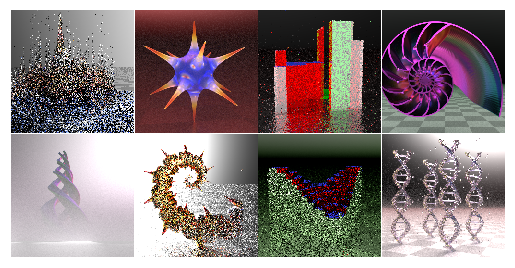

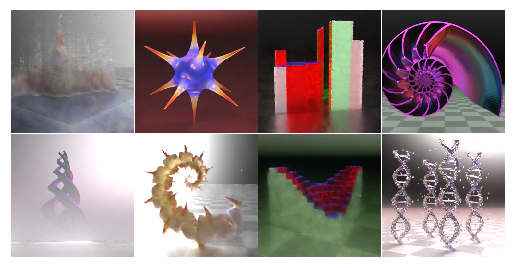

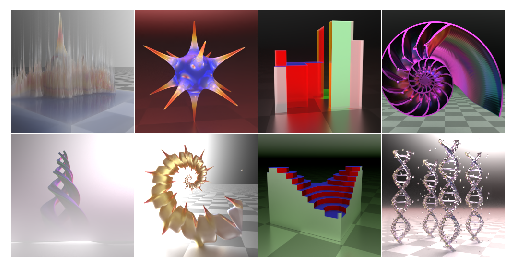

57600 0.02851482853293419
57856 0.034371666610240936
58112 0.01816622167825699
58368 0.014481771737337112
58624 0.016137028113007545
58880 0.013038466684520245
59136 0.015363230369985104
59392 0.017232630401849747
59648 0.01708129234611988
59904 0.01943521946668625
60160 0.017778173089027405
60416 0.022003233432769775
60672 0.03973521292209625
60928 0.04855608195066452
61184 0.036529865115880966
61440 0.03847096860408783
61696 0.04459938406944275
61952 0.041738204658031464
62208 0.022028950974345207
62464 0.029445432126522064
62720 0.02009572647511959
62976 0.025089312344789505
63232 0.02450609765946865
63488 0.02336202748119831
63744 0.019602911546826363
64000 0.02929486334323883
64256 0.015852797776460648
64512 0.029682805761694908
64768 0.012536222115159035
65024 0.021094422787427902
65280 0.014237510040402412
65536 0.016571154817938805


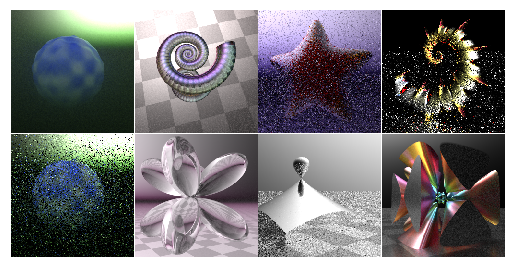

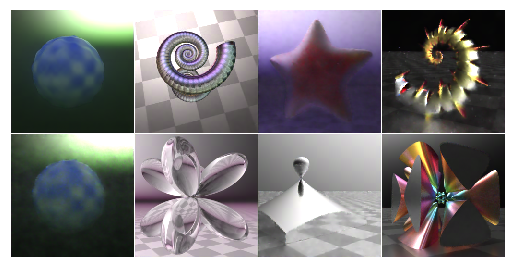

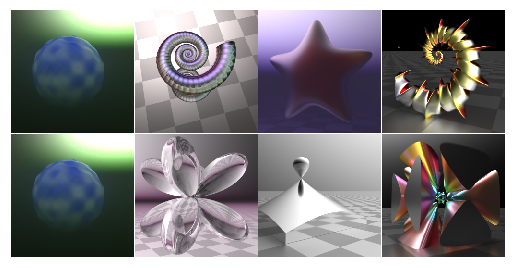

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
vgg16_head = vgg16_features[:4].to(device)
print(vgg16_head)

def lossfun(output, reference, input):
    # r1 = torch.mean(torch.abs(output-reference))
    r2 = torch.mean(torch.abs(vgg16_head(output)-vgg16_head(reference)))
    return r2
    # return 0.5*r1 + 0.5*r2

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((x, a), axis=1)
        output = model(m_in)
        loss = lossfun(output, y, x)
        regularize = 0.2 * torch.mean(torch.abs(model_params))
        (loss+regularize).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 8192 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1r.pth")